# Implementation of the Berstein-Polynoms as Keras-Loss

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
!pip install tensorflow_probability==0.8.0

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0
TF  Version 2.0.0


In [4]:
def my_scale(y):
  m = y.min()
  mm = y.max()
  return (y - m)/(mm - m)


## Berstein-Poly

$$
f_Y(y_i)|_{x_i}=f_Z(z_i)|_{x_i} \cdot h_y'(y_i)
$$

In [11]:
from tensorflow.keras.losses import Loss

class Bernstein_Poly(Loss):

  def __init__(self, len_theta, **kwargs):
    """

    """
    self.len_theta = len_theta
    self.M = len_theta - 1
    self.beta_dist_h = tfd.Beta(range(1,self.len_theta+1),range(self.len_theta,0,-1))
    self.beta_dist_h_dash = tfd.Beta(range(1,self.M+1),range(self.M,0,-1))
    self.stdnorm = tfd.Normal(0,1) #The distribution of z
    super(Bernstein_Poly, self).__init__(**kwargs)

  def call(self, y_obs, out):
    print('in loss', y_obs, out.shape)
    theta = self.to_theta(out)
    zz = self._eval_h(theta, y_obs)
    return -tf.math.reduce_mean(self.stdnorm.log_prob(zz) + tf.math.log(self._eval_h_dash(theta, y_obs)))

  def to_theta(self, out):
    """ Translates the output of the network `out` to the theta parameters

    Parameters
    ----------
    out : Tensor of shape (batch_size, len_theta)
    
    Returns
    -------
    theta parameters of shape (batch_size, len_theta)

    """
    #Calclutes theta_1 = h_1, theta_k = theta_k-1 + exp(h_k)
    bs = tf.shape(out)[0] 
    print('Estimated Batch Size:', bs)
    d = tf.concat( (tf.zeros((bs,1)), out[:,0:1], tf.math.exp(out[:,1:out.shape[1]])),axis=1)
    #Uncomment if you want softplus loss
    #d = tf.concat( (tf.zeros((bs,1)), out[:,0:1], tf.math.softplus(out[:,1:out.shape[1]])),axis=1)
    return tf.cumsum(d[:,1:], axis=1)

  def prob_y(self, out, y):
    """
      
    """
    theta = self.to_theta(out)
    zz = self._eval_h(theta, y)
    return self.stdnorm.prob(zz) * self._eval_h_dash(theta, y)

  def get_theta(out):
    return self.to_theta(out)

  def _eval_h(self, theta, y):
    y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
    by = self.beta_dist_h.prob(y) 
    return tf.reduce_mean(by * theta, axis=1)

  def _eval_h_dash(self, theta, y):
    y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
    by = self.beta_dist_h_dash.prob(y) 
    dtheta = theta[:,1:] - theta[:,0:-1]
    return tf.reduce_sum(by * dtheta, axis=1)

### Test code

* GPU Old Faithful 24.5 seconds for number of runs 10000
* GPU Old Faithful 16.9 seconds for number of runs 10000

In [12]:
b = Bernstein_Poly(9)
b.to_theta()

TypeError: to_theta() missing 1 required positional argument: 'out'

In [13]:
dur = np.asarray(
    (0.6694,0.3583,0.6667,0.6667,0.6667,0.3333,0.7306,0.7139,0.3389,0.8056,0.3056,0.9083,0.2694,0.8111,
     0.7306,0.2944,0.7778,0.3333,0.7889,0.7028,0.3167,0.8278,0.3333,0.6667,0.3333,0.6667,0.4722,0.75,
     0.6778,0.6194,0.5861,0.7444,0.3694,0.8139,0.4333,0.6917,0.3667,0.7944,0.3056,0.7667,0.3778,0.6889,
     0.3333,0.6667,0.3333,0.6667,0.3139,0.7111,0.3472,0.7444,0.4167,0.6667,0.2944,0.7222,0.3639,0.7472,
     0.6472,0.5556,0.6222,0.6667,0.325,0.8778,0.3333,0.6667,0.3333,0.6667,0.3333,0.6667,0.5889,0.3611,0.75,
     0.3361,0.6917,0.7,0.7222,0.3222,0.775,0.6361,0.6722,0.6944,0.7778,0.3028,0.6667,0.5,0.6667,0.3333,0.7417,
     0.3417,0.7083,0.3194,0.7778,0.2889,0.7306,0.2944,0.7667,0.3111,0.7417,0.2722,0.8389,0.3028,0.85,0.2722,0.7139,
     0.3333,0.6667,0.3333,0.7556,0.3333,0.6667,0.4889,0.7889,0.65,0.325,0.6861,0.3,0.7778,0.3056,0.7833,0.3528,0.7972,
     0.3028,0.6833,0.775,0.6667,0.3333,0.6667,0.6667,0.7028,0.6889,0.6556,0.625,0.7361,0.4111,0.6944,0.6333,0.7194,
     0.6444,0.7806,0.2833,0.8278,0.7111,0.7639,0.6667,0.6667,0.6667,0.6667,0.3306,0.7667,0.1389,0.8194,0.2889,0.7639,
     0.2833,0.7917,0.3056,0.75,0.3111,0.7417,0.7417,0.6667,0.8,0.6667,0.6667,0.3333,0.6667,0.3222,0.7639,0.3333,0.6167,
     0.4778,0.8056,0.575,0.7306,0.3,0.7333,0.4139,0.7528,0.35,0.725,0.7278,0.2972,0.8194,0.3028,0.6667,0.6667,0.6667,0.6444,
     0.3083,0.7833,0.3361,0.7444,0.3111,0.6944,0.3167,0.7083,0.5417,0.7028,0.3139,0.8306,0.3083,0.6667,0.3278,0.7944,0.6667,0.3333,
     0.6667,0.6667,0.3972,0.7361,0.7028,0.7278,0.3333,0.7417,0.2917,0.75,0.2694,0.7833,0.4278,0.6167,0.7056,0.3222,0.725,0.6667,0.6667,
     0.6667,0.7028,0.6667,0.6889,0.3139,0.7444,0.325,0.7028,0.2861,0.7417,0.7083,0.6611,0.7306,0.3278,0.7417,0.7111,0.3194,0.7361,0.5,
     0.6667,0.3333,0.6667,0.5472,0.3056,0.7694,0.3056,0.7694,0.7667,0.7083,0.3222,0.8306,0.3278,0.7167,0.7,0.7556,0.7333,0.7694,0.3333,
     0.6667,0.6667,0.6528,0.3333,0.75,0.3,0.6667,0.4583,0.7889,0.6611,0.325,0.8278,0.3083,0.8,0.6667,0.6667,0.6667,0.6667,0.6667,0.6667,
     0.6667,0.3333,0.6667,0.3222,0.7222,0.2778,0.7944,0.325,0.7806,0.3222,0.7361,0.3556,0.6806,0.3444,0.6667,0.6667,0.3333),
     np.float32
)

In [20]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam
optimizer = tf.keras.optimizers.RMSprop()

inputs = Input(shape=(1,))
to_bs = Dense(9, activation='linear', use_bias=False)(inputs)
model = Model(inputs, to_bs)
model.summary()
bern_poly = Bernstein_Poly(len_theta=9)
model.compile(loss=bern_poly)
x = np.ones((dur.shape[0],1))
import time
start = time.time()
epochs = 5000
history = model.fit(x,dur,epochs=epochs, batch_size=299, verbose=0)
end = time.time()
print(end - start, 'seconds for number of runs ', epochs)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________
in loss Tensor("dense_5_target:0", shape=(None, None), dtype=float32) (None, 9)
Estimated Batch Size: Tensor("loss_3/dense_5_loss/strided_slice:0", shape=(), dtype=int32)
in loss Tensor("IteratorGetNext:1", shape=(299, 1), dtype=float32) (299, 9)
Estimated Batch Size: Tensor("loss/dense_5_loss/strided_slice:0", shape=(), dtype=int32)
in loss Tensor("IteratorGetNext:1", shape=(299, 1), dtype=float32) (299, 9)
Estimated Batch Size: Tensor("loss/dense_5_loss/strided_slice:0", shape=(), dtype=int32)
9.889384508132935 seconds 

-0.5687499940395355

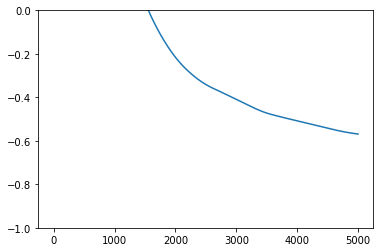

In [21]:
plt.plot(history.history['loss'])
plt.ylim(-1,0)
np.mean(history.history['loss'][-10:])

Estimated Batch Size: tf.Tensor(1000, shape=(), dtype=int32)
Estimated Batch Size: tf.Tensor(2, shape=(), dtype=int32)


<tf.Tensor: id=64454, shape=(2, 9), dtype=float32, numpy=
array([[-3.8118813 , -3.5543208 , -0.7157326 , -0.3089999 , -0.2600607 ,
        -0.24124955, -0.21094358,  0.05961952,  9.632695  ],
       [-3.8118813 , -3.5543208 , -0.7157326 , -0.3089999 , -0.2600607 ,
        -0.24124955, -0.21094358,  0.05961952,  9.632695  ]],
      dtype=float32)>

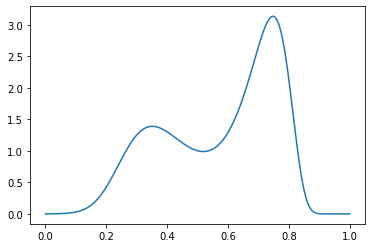

In [22]:
out = model(np.ones((1000,1),dtype='float32'))
yy = np.linspace(0,1,1000, dtype=np.float32).reshape((-1,1))
dense_y = bern_poly.prob_y(out, yy)
plt.plot(yy, dense_y)
bern_poly.to_theta(out[0:2,:])

In [17]:
inputs = Input(shape=(1,))
x = np.ones((dur.shape[0],1)) #For unconditional we just input ones
len_theta = 9 #Number of coefficients
h = Dense(100, activation='tanh')(inputs)
h = Dense(100, activation='tanh')(h)
to_bs = Dense(len_theta, activation='linear')(h) #Last layer needs to be linear
model = Model(inputs, to_bs)  #Compiling the model
bern_poly = Bernstein_Poly(len_theta=len_theta) #Initalizing the loss with correct length 
model.compile(loss=bern_poly) #Adding the loss

import time
start = time.time()
epochs = 15000
history = model.fit(x,dur,epochs=epochs, batch_size=299, verbose=0)
end = time.time()
print(end - start, 'seconds for number of runs ', epochs)

in loss Tensor("dense_4_target:0", shape=(None, None), dtype=float32) (None, 9)
Estimated Batch Size: Tensor("loss_2/dense_4_loss/strided_slice:0", shape=(), dtype=int32)
in loss Tensor("IteratorGetNext:1", shape=(299, 1), dtype=float32) (299, 9)
Estimated Batch Size: Tensor("loss/dense_4_loss/strided_slice:0", shape=(), dtype=int32)
in loss Tensor("IteratorGetNext:1", shape=(299, 1), dtype=float32) (299, 9)
Estimated Batch Size: Tensor("loss/dense_4_loss/strided_slice:0", shape=(), dtype=int32)
48.92111420631409 seconds for number of runs  15000


-0.6139916777610779

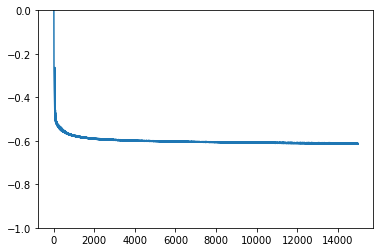

In [18]:
plt.plot(history.history['loss'])
plt.ylim(-1,0)
np.mean(history.history['loss'][-10:])

Estimated Batch Size: tf.Tensor(1000, shape=(), dtype=int32)
Estimated Batch Size: tf.Tensor(2, shape=(), dtype=int32)


<tf.Tensor: id=53427, shape=(2, 9), dtype=float32, numpy=
array([[-9.211064  , -2.2873774 , -0.17426944, -0.1742694 , -0.17426938,
        -0.17426936, -0.17426932,  0.13455972, 10.316385  ],
       [-9.211064  , -2.2873774 , -0.17426944, -0.1742694 , -0.17426938,
        -0.17426936, -0.17426932,  0.13455972, 10.316385  ]],
      dtype=float32)>

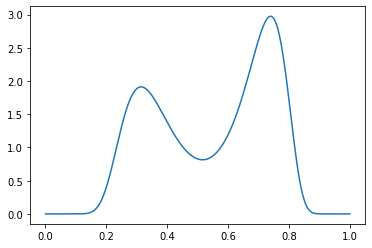

In [19]:
out = model(np.ones((1000,1),dtype='float32'))
yy = np.linspace(0,1,1000, dtype=np.float32).reshape((-1,1))
dense_y = bern_poly.prob_y(out, yy)
plt.plot(yy, dense_y)
bern_poly.to_theta(out[0:2,:])

### Junck Below

In [26]:
len_theta = 4

def init(len_theta):
  M = len_theta - 1
  beta_shapes = np.zeros((len_theta, 2), dtype='float32')
  for m in range(0,len_theta):
      print(m+1, M-m+1)
      beta_shapes[m,0] = m+1
      beta_shapes[m,1] = M-m+1    
  beta_dist = tfd.Beta(beta_shapes[:,0], beta_shapes[:,1])
  return beta_dist

def eval_h(theta, y):
  y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
  by = beta_dist.prob(y) 
  return tf.reduce_mean(by * theta, axis=1)

#### Testing h
y = np.array((0.00,0.25,0.50,0.75,1.00), dtype='float32').reshape(-1,1)
theta = np.array(
    (
        0.1,1.1,4,12,
        2,3,4,5,
        6,7,8,9,
        10,11,12,13,
        14,15,16,17
    )
    , dtype='float32').reshape(5,4)

h_res_r = np.array((0.1,2.75,7.5,12.25,17))

beta_dist = init(theta.shape[1])
h_python = eval_h(theta,y)
h_python

1 4
2 3
3 2
4 1


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.10003  ,  2.7500002,  7.5      , 12.250001 , 16.99997  ],
      dtype=float32)>

In [27]:
tfd.Beta(4,1, allow_nan_stats=False).prob(1)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [28]:

y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
by = beta.prob(y) 

NameError: ignored

In [0]:
tf.reduce_mean(by * theta, axis=1)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.10003  ,  2.7500002,  7.5      , 12.25     , 16.99997  ],
      dtype=float32)>

In [0]:
tfd.Beta(1, 4).prob(1.0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [0]:
tfd.Beta(beta_shapes[0,0], beta_shapes[0,1]).prob(0.25)

<tf.Tensor: shape=(), dtype=float64, numpy=1.6875000000000004>

In [0]:
beta.prob(0.25)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0., 0., 0., 0.])>

In [0]:


# theta = np.repeat(np.array((0.1, 1.1, 4, 12)).reshape((1,4)),4, axis=0)
print('theta ', theta)
print('y ', y)
#print('h_ok', h_ok(theta, y))
#print('h', h(theta, y))

theta  [[ 0.1  1.1  4.  12. ]
 [ 2.   3.   4.   5. ]
 [ 6.   7.   8.   9. ]
 [10.  11.  12.  13. ]
 [14.  15.  16.  17. ]]
y  [[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]


In [0]:
@tf.function
def h(theta, y, l=None):
  
  #Hack Attack
  #tfd.Beta(3,1).prob(1.0 - 1E-8) --> yields NaN 
  y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
  if (l == None):
    M = len(theta) - 1
  else:
    M = l - 1
  dd = tf.zeros_like(y)
  for m in range(0,len(theta)):
    t = theta[m]
  #for m,t in enumerate(theta):
    dd = dd + t * tfd.Beta(m+1,M-m+1).prob(y)   
  return dd / (M + 1.0)

In [0]:
@tf.function
def h_dash(theta, y, l=None):
  #Hack Attack
  #tfd.Beta(3,1).prob(1.0 - 1E-8) --> yields NaN 
  y = tf.clip_by_value(y,1E-5, 1.0-1E-5)
  if (l == None):
    M = len(theta) - 1
  else:
    M = l - 1
  dd = tf.zeros_like(y)
  for m in range(0,M):
    dd = dd + (theta[m+1] - theta[m]) * tfd.Beta(m+1,M-m).prob(y)   
  return dd #* M / (M + 1.0)